<a href="https://colab.research.google.com/github/VandanGupte101727/ML-F1-model/blob/main/Working%20ML%20model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving fatal_accidents_drivers.csv to fatal_accidents_drivers (3).csv
Saving fatal_accidents_marshalls.csv to fatal_accidents_marshalls (3).csv
Saving red_flags.csv to red_flags (3).csv
Saving safety_cars.csv to safety_cars (3).csv

DataFrame df1 info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Driver            50 non-null     object 
 1   Age               49 non-null     float64
 2   Date Of Accident  50 non-null     object 
 3   Event             43 non-null     object 
 4   Car               50 non-null     object 
 5   Session           50 non-null     object 
dtypes: float64(1), object(5)
memory usage: 2.5+ KB

DataFrame df2 info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0  

/tmp/ipython-input-4-61040748.py:48: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df2['Date Of Accident'] = pd.to_datetime(df2['Date Of Accident'], errors='coerce')


Random Forest Accuracy: 0.7777777777777778


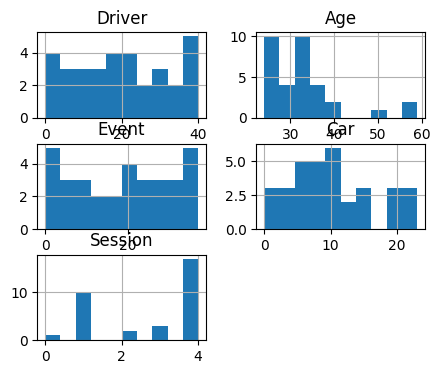

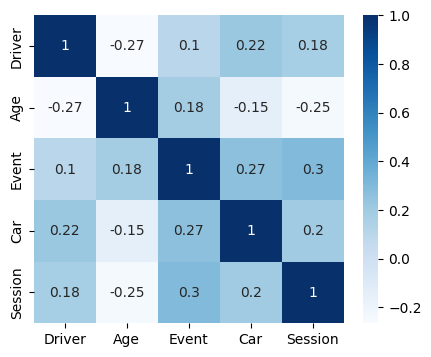

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier

uploaded = files.upload()

df1 = pd.read_csv("fatal_accidents_drivers.csv")
df2 = pd.read_csv("fatal_accidents_marshalls.csv")
df3 = pd.read_csv("red_flags.csv")
df4 = pd.read_csv("safety_cars.csv")

for i, df in enumerate([df1, df2, df3, df4], 1):
    print(f"\nDataFrame df{i} info:")
    df.info()

df1.dropna(inplace=True)
df2.dropna(inplace=True)
df3.dropna(inplace=True)
df4.dropna(inplace=True)

for i, df in enumerate([df1, df2, df3, df4], 1):
    print(f"\nCleaned df{i} info:")
    df.info()

print(df1.columns)
print(df2.columns)
print(df3.columns)
print(df4.columns)

le = LabelEncoder()
df1['Driver'] = le.fit_transform(df1['Driver'])
df1['Event'] = le.fit_transform(df1['Event'])
df1['Car'] = le.fit_transform(df1['Car'])
df1['Session'] = le.fit_transform(df1['Session'])

x1 = df1.drop('Session', axis=1)
y1 = df1['Session'].astype(int)
x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size=0.2)
train_data1 = x1_train.join(y1_train)

# Convert Date Of Accident to datetime and numerical
df2['Date Of Accident'] = pd.to_datetime(df2['Date Of Accident'], errors='coerce')
df2['Accident_Timestamp'] = df2['Date Of Accident'].astype(np.int64) // 10**9
df2.drop('Date Of Accident', axis=1, inplace=True)
df2['Name'] = le.fit_transform(df2['Name'])
df2['Event'] = le.fit_transform(df2['Event'])

x2 = df2.drop('Event', axis=1)
y2 = df2['Event']
x2_train, x2_test, y2_train, y2_test = train_test_split(x2, y2, test_size=0.2)
train_data2 = x2_train.join(y2_train)

df3['Race'] = le.fit_transform(df3['Race'])
df3['Resumed'] = le.fit_transform(df3['Resumed'])
df3['Incident'] = le.fit_transform(df3['Incident'])
df3['Excluded'] = le.fit_transform(df3['Excluded'])

x3 = df3.drop('Incident', axis=1)
y3 = df3['Incident']
x3_train, x3_test, y3_train, y3_test = train_test_split(x3, y3, test_size=0.2)
train_data3 = x3_train.join(y3_train)

df4['Race'] = le.fit_transform(df4['Race'])
df4['Cause'] = le.fit_transform(df4['Cause'])
df4['Deployed'] = le.fit_transform(df4['Deployed'])
df4['Retreated'] = le.fit_transform(df4['Retreated'])

x4 = df4.drop('Deployed', axis=1)
y4 = df4['Deployed']
x4_train, x4_test, y4_train, y4_test = train_test_split(x4, y4, test_size=0.2)
train_data4 = x4_train.join(y4_train)

train_data1.head()

numerical_train_data1 = train_data1.select_dtypes(include=np.number)
numerical_train_data1.hist(figsize=(5,4))
numerical_train_data1.corr()

# Safe feature engineering (no div-by-zero or inf)
train_data1['Session_ratio'] = train_data1['Session'] / train_data1['Driver'].replace(0, np.nan)
train_data1['Driver_age_ratio'] = train_data1['Driver'] / train_data1['Age'].replace(0, np.nan)
train_data1.replace([np.inf, -np.inf], np.nan, inplace=True)
train_data1.fillna(0, inplace=True)

# One-hot encoding
train_data1 = train_data1.join(pd.get_dummies(train_data1['Driver'], prefix='Driver'))
train_data1 = train_data1.join(pd.get_dummies(train_data1['Event'], prefix='Event'))
train_data1.drop(['Driver', 'Event'], axis=1, inplace=True)

plt.figure(figsize=(5,4))
sns.heatmap(numerical_train_data1.corr(), annot=True, cmap="Blues")


x1_train, y1_train = train_data1.drop('Session', axis=1), train_data1['Session']
x1_train = x1_train.apply(pd.to_numeric, errors='coerce').fillna(0)
y1_train = y1_train.astype(int)

test_data1 = x1_test.join(y1_test)
test_data1['Session_ratio'] = test_data1['Session'] / test_data1['Driver'].replace(0, np.nan)
test_data1['Driver_age_ratio'] = test_data1['Driver'] / test_data1['Age'].replace(0, np.nan)
test_data1.replace([np.inf, -np.inf], np.nan, inplace=True)
test_data1.fillna(0, inplace=True)

test_data1 = test_data1.join(pd.get_dummies(test_data1['Driver'], prefix='Driver'))
test_data1 = test_data1.join(pd.get_dummies(test_data1['Event'], prefix='Event'))
test_data1.drop(['Driver', 'Event'], axis=1, inplace=True)

test_data1 = test_data1.reindex(columns=train_data1.columns, fill_value=0)
x1_test, y1_test = test_data1.drop('Session', axis=1), test_data1['Session']
x1_test = x1_test.apply(pd.to_numeric, errors='coerce').fillna(0)
y1_test = y1_test.astype(int)

# Fit Random Forest Classifier
forest = RandomForestClassifier()
forest.fit(x1_train, y1_train)
print("Random Forest Accuracy:", forest.score(x1_test, y1_test))
